<a href="https://colab.research.google.com/github/MayerT1/ACI_Collaboration/blob/main/Broken_Sewanee_Lidar_PAI_9_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prep Working Folders

Note thse files and processsing is "heavy" so we are using GDrive instead of the temp Colab space. This is to help with checkpoints in files. If the ram crashes the expored files can be grabbed form GDrive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
!mkdir /content/drive/MyDrive/GEDI_LAS_Comp

Note this folder cna be detleted at the end of the training  

In [2]:
%cd /content/drive/MyDrive/GEDI_LAS_Comp

/content/drive/MyDrive/GEDI_LAS_Comp


In [ ]:
!pwd

/content/drive/MyDrive/GEDI_LAS_Comp


In [ ]:
path = "/content/drive/MyDrive/GEDI_LAS_Comp"

In [ ]:
path

'/content/drive/MyDrive/GEDI_LAS_Comp'

# Environment Set-up

In [7]:
!pip install laspy pyproj open3d plotly rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 56.5 MB/s eta 0:00:00


In [4]:
import laspy
from pyproj import CRS
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
import glob
import shutil
import plotly.graph_objects as go
import pandas as pd
import glob
from shapely.geometry import Point
import geopandas as gpd

# Fetch and Derived PAI

See the ipynb and zenodo description fo rmore details on the product

Fetch Derived PAI
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.17065493.svg)](https://doi.org/10.5281/zenodo.17065493)


In [5]:
import requests
import os
import zipfile
from google.colab import drive



# . Set target folder
target_dir = "/content/drive/MyDrive/GEDI_LAS_Comp"
os.makedirs(target_dir, exist_ok=True)

# . Zenodo record ID
record_id = "17065493"

# . Fetch record metadata
r = requests.get(f"https://zenodo.org/api/records/{record_id}")
r.raise_for_status()
files = r.json()['files']

# . Download each file
for file_info in files:
    filename = file_info['key']
    download_url = file_info['links']['self']
    file_path = os.path.join(target_dir, filename)

    print(f"Downloading {filename} ...")
    with requests.get(download_url, stream=True) as r_file:
        r_file.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r_file.iter_content(chunk_size=8192):
                f.write(chunk)
    print(f"Downloaded: {filename}")

    # 6. If ZIP file, extract it
    if filename.endswith(".zip"):
        print(f"Extracting {filename} ...")
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(target_dir)
        print(f"Extraction completed for {filename}")


Downloaded: 1982317NW_PAI_10m.tif
Downloaded: Sewanee_Domain_GEDI02_B_GEDI02_B_filt.csv
Downloaded: PAI_from_Las_TN.ipynb


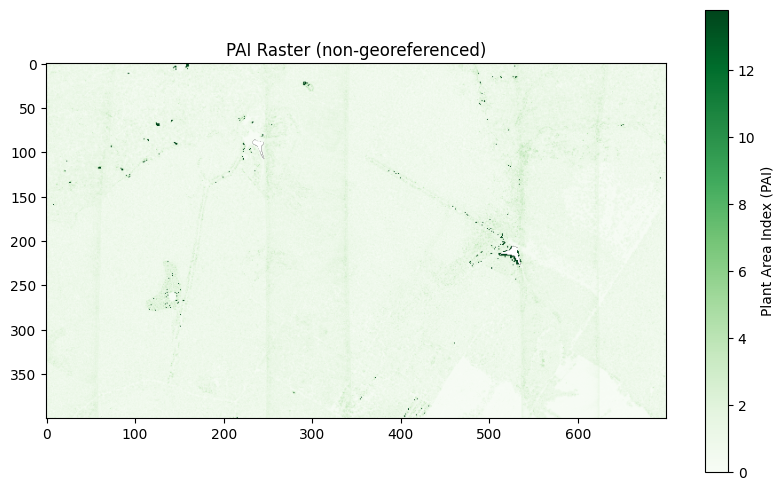

In [8]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

raster_path = "/content/drive/MyDrive/GEDI_LAS_Comp/1982317NW_PAI_10m.tif"

with rasterio.open(raster_path) as src:
    array = src.read(1, masked=True).astype(float)

# Mask invalid values
array = np.ma.masked_invalid(array)

plt.figure(figsize=(10,6))
plt.imshow(array, cmap="Greens", origin="upper")
plt.colorbar(label="Plant Area Index (PAI)")
plt.title("PAI Raster (non-georeferenced)")
plt.show()


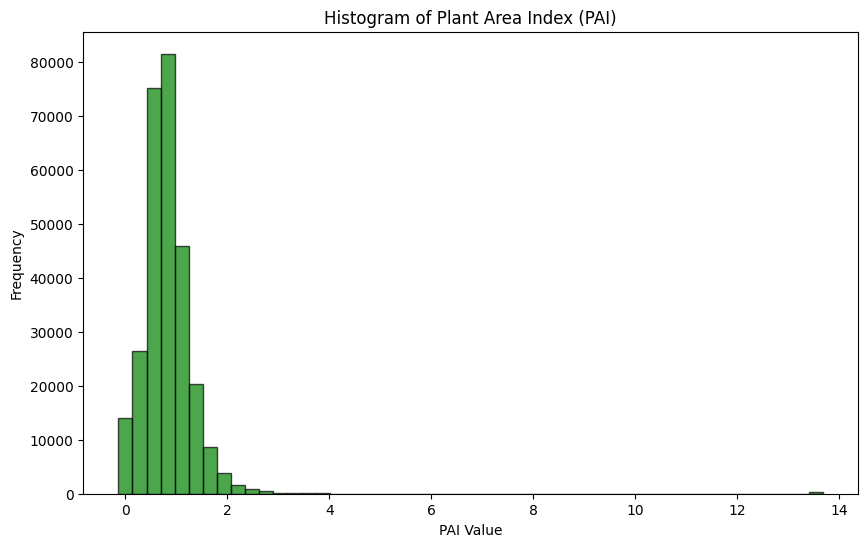

In [9]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

raster_path = "/content/drive/MyDrive/GEDI_LAS_Comp/1982317NW_PAI_10m.tif"

# Open raster
with rasterio.open(raster_path) as src:
    array = src.read(1, masked=True).astype(float)  # Read first band

# Mask invalid values
array = np.ma.masked_invalid(array)

# Flatten valid values for histogram
valid_values = array.compressed()  # removes masked/NaN

# Compute histogram
hist, bins = np.histogram(valid_values, bins=50)  # 50 bins, adjust if needed

# Plot histogram
plt.figure(figsize=(10,6))
plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]), color='green', edgecolor='black', alpha=0.7)
plt.xlabel("PAI Value")
plt.ylabel("Frequency")
plt.title("Histogram of Plant Area Index (PAI)")
plt.show()


Use the GEDI CSVs

# Clip GEDI to bounds of Las (reduce processing)

In [12]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import rasterio

# --- Step 1: Load TIFF and get bounding box ---
tif_path = "/content/drive/MyDrive/GEDI_LAS_Comp/1982317NW_PAI_10m.tif"

with rasterio.open(tif_path) as src:
    bounds = src.bounds  # returns (left, bottom, right, top)

minx, miny, maxx, maxy = bounds.left, bounds.bottom, bounds.right, bounds.top

# --- Step 2: Create bounding box polygon and assign CRS manually ---
# Your raster seems to be in EPSG:6576 (Tennessee State Plane)
bbox_poly = gpd.GeoSeries([box(minx, miny, maxx, maxy)], crs="EPSG:6576")

# --- Step 3: Reproject bounding box to EPSG:4326 ---
bbox_poly_wgs84 = bbox_poly.to_crs(epsg=4326)

# --- Step 4: Load CSV points ---
df = pd.read_csv("/content/drive/MyDrive/GEDI_LAS_Comp/Sewanee_Domain_GEDI02_B_GEDI02_B_filt.csv")

gdf_points = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.lon, df.lat),
    crs="EPSG:4326"
)

# --- Step 5: Clip points to TIFF bounding box ---
clipped_points = gdf_points[gdf_points.within(bbox_poly_wgs84.iloc[0])]

# --- Step 6: Save / use result ---
clipped_points.to_csv("/content/drive/MyDrive/GEDI_LAS_Comp/GEDI_csvs/clipped_points_from_tif.csv", index=False)

print(f"Original points: {len(df)}")
print(f"Clipped points: {len(clipped_points)}")


Original points: 11611
Clipped points: 322


In [ ]:
# import pandas as pd
# import geopandas as gpd
# from shapely.geometry import Point, box
# import laspy
# from pyproj import CRS

# # --- Step 1: Load LAS and get bounding box ---
# las = laspy.read("/content/drive/MyDrive/GEDI_LAS_Comp/1982317NW.las")

# minx, maxx = las.x.min(), las.x.max()
# miny, maxy = las.y.min(), las.y.max()

# # Create bounding box polygon in LAS CRS (EPSG:6576)
# las_crs = CRS.from_epsg(6576)
# bbox_poly = gpd.GeoSeries([box(minx, miny, maxx, maxy)], crs=las_crs)

# # --- Step 2: Reproject bounding box to EPSG:4326 ---
# bbox_poly_wgs84 = bbox_poly.to_crs(epsg=4326)

# # --- Step 3: Load CSV points ---
# df = pd.read_csv("/content/drive/MyDrive/GEDI_LAS_Comp/Sewanee_Domain_GEDI02_B_GEDI02_B_filt.csv")

# # Assuming CSV has columns 'longitude' and 'latitude' (adjust if names differ)
# gdf_points = gpd.GeoDataFrame(
#     df,
#     geometry=gpd.points_from_xy(df.lon, df.lat),
#     crs="EPSG:4326"
# )

# # --- Step 4: Clip points to LAS bounding box ---
# clipped_points = gdf_points[gdf_points.within(bbox_poly_wgs84.iloc[0])]

# # --- Step 5: Save / use result ---
# clipped_points.to_csv("/content/drive/MyDrive/GEDI_LAS_Comp/GEDI_csvs/clipped_points.csv", index=False)

# print(f"Original points: {len(df)}")
# print(f"Clipped points: {len(clipped_points)}")


Original points: 31982
Clipped points: 560


View the clipped GEDI Csv to the .las bounds

In [13]:
clipped_points

,lat,lon,geolocation/solar_elevation,geolocation/local_beam_elevation,selected_l2a_algorithm,geolocation/degrade_flag,l2b_quality_flag,geolocation/digital_elevation_model,geolocation/elev_lowestmode,geolocation/elev_highestreturn,...,pavd_z,cover,cover_z,product,Beam,fileName,date,Beam_Type,AOI,geometry
238,35.225911,-85.952789,6.330425,1.485430,2,0,1,459.937866,447.504364,454.635834,...,"[0.18133112788200378, 0.11548267304897308, 0.0...",0.438233,"[0.43823322653770447, 0.11666984111070633, 0.0...",GEDI_L2B,BEAM1000,GEDI02_B_2024169103448_O31228_02_T05264_02_004...,2024-06-17,Power,Sewanee_Domain_GEDI02_B,POINT (-85.95279 35.22591)
239,35.226252,-85.952335,6.330932,1.485430,2,0,1,428.120880,433.156586,444.805939,...,"[0.2739972770214081, 0.2744947075843811, 0.145...",0.754583,"[0.7545831799507141, 0.5155324339866638, 0.037...",GEDI_L2B,BEAM1000,GEDI02_B_2024169103448_O31228_02_T05264_02_004...,2024-06-17,Power,Sewanee_Domain_GEDI02_B,POINT (-85.95234 35.22625)
335,35.218874,-85.952065,6.327698,1.486174,2,0,1,564.642151,570.258484,575.150024,...,"[0.08488406985998154, 0.04244203492999077, -0....",0.191135,"[0.19113504886627197, 0.0, 0.0, 0.0, 0.0, 0.0,...",GEDI_L2B,BEAM1011,GEDI02_B_2024169103448_O31228_02_T05264_02_004...,2024-06-17,Power,Sewanee_Domain_GEDI02_B,POINT (-85.95207 35.21887)
336,35.219923,-85.950675,6.329240,1.486175,2,0,1,568.325562,574.734497,578.244446,...,"[0.002883615205064416, 0.001441807602532208, -...",0.010668,"[0.007183022331446409, 0.0, 0.0, 0.0, 0.0, 0.0...",GEDI_L2B,BEAM1011,GEDI02_B_2024169103448_O31228_02_T05264_02_004...,2024-06-17,Power,Sewanee_Domain_GEDI02_B,POINT (-85.95067 35.21992)
337,35.221319,-85.948823,6.331296,1.486176,2,0,1,567.739868,575.495239,580.536133,...,"[0.13761571049690247, 0.06880785524845123, -0....",0.291376,"[0.2909294664859772, 0.0, 0.0, 0.0, 0.0, 0.0, ...",GEDI_L2B,BEAM1011,GEDI02_B_2024169103448_O31228_02_T05264_02_004...,2024-06-17,Power,Sewanee_Domain_GEDI02_B,POINT (-85.94882 35.22132)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10947,35.217719,-85.952949,-12.517460,1.564300,2,0,1,572.046143,556.305054,582.342285,...,"[0.06903454661369324, 0.08533059805631638, 0.1...",0.857081,"[0.8570812940597534, 0.8301624059677124, 0.781...",GEDI_L2B,BEAM1000,GEDI02_B_2021135083748_O13719_03_T08849_02_003...,2021-05-15,Power,Sewanee_Domain_GEDI02_B,POINT (-85.95295 35.21772)
10948,35.217371,-85.952489,-12.517323,1.564300,1,0,1,574.444214,558.450867,585.049988,...,"[0.06378267705440521, 0.09275759756565094, 0.1...",0.855521,"[0.8555208444595337, 0.8305472731590271, 0.770...",GEDI_L2B,BEAM1000,GEDI02_B_2021135083748_O13719_03_T08849_02_003...,2021-05-15,Power,Sewanee_Domain_GEDI02_B,POINT (-85.95249 35.21737)
10949,35.217022,-85.952029,-12.517188,1.564300,1,0,1,574.485535,560.517456,585.430725,...,"[0.049635954201221466, 0.10280416160821915, 0....",0.846452,"[0.8464522957801819, 0.8261682391166687, 0.743...",GEDI_L2B,BEAM1000,GEDI02_B_2021135083748_O13719_03_T08849_02_003...,2021-05-15,Power,Sewanee_Domain_GEDI02_B,POINT (-85.95203 35.21702)
10950,35.216673,-85.951569,-12.517052,1.564300,2,0,1,574.485535,556.055847,583.479248,...,"[0.05897676572203636, 0.08795278519392014, 0.1...",0.797157,"[0.7971569299697876, 0.7649346590042114, 0.685...",GEDI_L2B,BEAM1000,GEDI02_B_2021135083748_O13719_03_T08849_02_003...,2021-05-15,Power,Sewanee_Domain_GEDI02_B,POINT (-85.95157 35.21667)


Display this on a map to verify

Computationally  intensive to commented off for run all. Comment on if you want to run

In [14]:
import pandas as pd
import geopandas as gpd
import folium

# --- Load clipped points as plain DataFrame ---
df = pd.read_csv("/content/drive/MyDrive/GEDI_LAS_Comp/GEDI_csvs/clipped_points.csv")

# --- Convert to GeoDataFrame ---
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.lon, df.lat),
    crs="EPSG:4326"
)

# --- Create folium map ---
m = folium.Map(
    location=[gdf.geometry.y.mean(), gdf.geometry.x.mean()],
    zoom_start=12
)

# Add points as circle markers
for _, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=2,
        color="green",
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

m


Buffer gedi to 25m diamater plots | requirirng a reprojeciton

In [15]:
import pandas as pd
import geopandas as gpd

# --- Step 1: Load CSV into GeoDataFrame ---
df = pd.read_csv("/content/drive/MyDrive/GEDI_LAS_Comp/GEDI_csvs/clipped_points_from_tif.csv") #/content/drive/MyDrive/GEDI_LAS_Comp/GEDI_csvs/clipped_points.csv
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.lon, df.lat),
    crs="EPSG:4326"
)

# --- Step 2: Reproject to UTM (zone 16N covers Tennessee) ---
gdf_utm = gdf.to_crs(epsg=26916)

# --- Step 3: Buffer points by 12.5 meters (25 m diameter) ---
gdf_utm["Plot"] = gdf_utm.geometry.buffer(12.5)

# --- Step 4: Reproject back to EPSG:4326 for saving/visualization ---
gdf_out = gdf_utm.to_crs(epsg=4326)

# Keep original point geometry AND Plot polygons
gdf_out["geometry"] = gdf.geometry  # restore original point geom
# Polygons are in new "Plot" column


In [17]:
gdf_out

,lat,lon,geolocation/solar_elevation,geolocation/local_beam_elevation,selected_l2a_algorithm,geolocation/degrade_flag,l2b_quality_flag,geolocation/digital_elevation_model,geolocation/elev_lowestmode,geolocation/elev_highestreturn,...,cover,cover_z,product,Beam,fileName,date,Beam_Type,AOI,geometry,Plot
0,35.225911,-85.952789,6.330425,1.485430,2,0,1,459.937866,447.504364,454.635834,...,0.438233,"[0.43823322653770447, 0.11666984111070633, 0.0...",GEDI_L2B,BEAM1000,GEDI02_B_2024169103448_O31228_02_T05264_02_004...,2024-06-17,Power,Sewanee_Domain_GEDI02_B,POINT (-85.95279 35.22591),"POLYGON ((595310.687 3898598.625, 595310.627 3..."
1,35.226252,-85.952335,6.330932,1.485430,2,0,1,428.120880,433.156586,444.805939,...,0.754583,"[0.7545831799507141, 0.5155324339866638, 0.037...",GEDI_L2B,BEAM1000,GEDI02_B_2024169103448_O31228_02_T05264_02_004...,2024-06-17,Power,Sewanee_Domain_GEDI02_B,POINT (-85.95234 35.22625),"POLYGON ((595351.55 3898636.832, 595351.49 389..."
2,35.218874,-85.952065,6.327698,1.486174,2,0,1,564.642151,570.258484,575.150024,...,0.191135,"[0.19113504886627197, 0.0, 0.0, 0.0, 0.0, 0.0,...",GEDI_L2B,BEAM1011,GEDI02_B_2024169103448_O31228_02_T05264_02_004...,2024-06-17,Power,Sewanee_Domain_GEDI02_B,POINT (-85.95207 35.21887),"POLYGON ((595384.734 3897818.85, 595384.674 38..."
3,35.219923,-85.950675,6.329240,1.486175,2,0,1,568.325562,574.734497,578.244446,...,0.010668,"[0.007183022331446409, 0.0, 0.0, 0.0, 0.0, 0.0...",GEDI_L2B,BEAM1011,GEDI02_B_2024169103448_O31228_02_T05264_02_004...,2024-06-17,Power,Sewanee_Domain_GEDI02_B,POINT (-85.95067 35.21992),"POLYGON ((595510.087 3897936.502, 595510.027 3..."
4,35.221319,-85.948823,6.331296,1.486176,2,0,1,567.739868,575.495239,580.536133,...,0.291376,"[0.2909294664859772, 0.0, 0.0, 0.0, 0.0, 0.0, ...",GEDI_L2B,BEAM1011,GEDI02_B_2024169103448_O31228_02_T05264_02_004...,2024-06-17,Power,Sewanee_Domain_GEDI02_B,POINT (-85.94882 35.22132),"POLYGON ((595676.979 3898093.053, 595676.919 3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,35.217719,-85.952949,-12.517460,1.564300,2,0,1,572.046143,556.305054,582.342285,...,0.857081,"[0.8570812940597534, 0.8301624059677124, 0.781...",GEDI_L2B,BEAM1000,GEDI02_B_2021135083748_O13719_03_T08849_02_003...,2021-05-15,Power,Sewanee_Domain_GEDI02_B,POINT (-85.95295 35.21772),"POLYGON ((595305.662 3897689.901, 595305.602 3..."
318,35.217371,-85.952489,-12.517323,1.564300,1,0,1,574.444214,558.450867,585.049988,...,0.855521,"[0.8555208444595337, 0.8305472731590271, 0.770...",GEDI_L2B,BEAM1000,GEDI02_B_2021135083748_O13719_03_T08849_02_003...,2021-05-15,Power,Sewanee_Domain_GEDI02_B,POINT (-85.95249 35.21737),"POLYGON ((595347.924 3897651.678, 595347.864 3..."
319,35.217022,-85.952029,-12.517188,1.564300,1,0,1,574.485535,560.517456,585.430725,...,0.846452,"[0.8464522957801819, 0.8261682391166687, 0.743...",GEDI_L2B,BEAM1000,GEDI02_B_2021135083748_O13719_03_T08849_02_003...,2021-05-15,Power,Sewanee_Domain_GEDI02_B,POINT (-85.95203 35.21702),"POLYGON ((595390.186 3897613.454, 595390.126 3..."
320,35.216673,-85.951569,-12.517052,1.564300,2,0,1,574.485535,556.055847,583.479248,...,0.797157,"[0.7971569299697876, 0.7649346590042114, 0.685...",GEDI_L2B,BEAM1000,GEDI02_B_2021135083748_O13719_03_T08849_02_003...,2021-05-15,Power,Sewanee_Domain_GEDI02_B,POINT (-85.95157 35.21667),"POLYGON ((595432.453 3897575.188, 595432.393 3..."


Odd Hack
to save this buffered CSV need to drop "geometry" if intrested in chekc poitns run these to produce this geojson

In [ ]:
# gdf_out = gdf_out.drop('geometry', axis=1)
# gdf_out

In [ ]:
# print(gdf_out.columns.tolist())

['lat', 'lon', 'geolocation/solar_elevation', 'geolocation/local_beam_elevation', 'selected_l2a_algorithm', 'geolocation/degrade_flag', 'l2b_quality_flag', 'geolocation/digital_elevation_model', 'geolocation/elev_lowestmode', 'geolocation/elev_highestreturn', 'rh100', 'shot_number', 'num_detectedmodes', 'sensitivity', 'land_cover_data/leaf_off_flag', 'pgap_theta_z', 'pai', 'pai_z', 'fhd_normal', 'pavd_z', 'cover', 'cover_z', 'product', 'Beam', 'fileName', 'date', 'Plot']


In [ ]:
# # # --- Step 5: Save ---
# gdf_out.to_file("/content/drive/MyDrive/GEDI_LAS_Comp/GEDI_csvs/clipped_points_with_plots.geojson", driver="GeoJSON")

Add to map to verfiy

Computationally  intensive to commented off for run all. Comment on if you want to run

In [16]:
import folium
import geopandas as gpd

# Points are WGS84
gdf_out = gdf_out.set_crs("EPSG:4326", allow_override=True)

# --- Build polygon GeoDataFrame from the Plot column (which is in EPSG:26916) ---
# Keep only safe/simple attributes to avoid JSON serialization issues
wanted = [c for c in ["lat","lon","product","Beam","fileName","date"] if c in gdf_out.columns]

plots_utm = gpd.GeoDataFrame(
    gdf_out[wanted].copy(),      # <- no geometry columns here
    geometry=gdf_out["Plot"],    # <- make Plot the active geometry
    crs="EPSG:26916"
)

# Reproject polygons to WGS84 for web mapping
plots = plots_utm.to_crs(epsg=4326)

# (Optional) absolutely safest: only geometry, no properties
plots_simple = plots[["geometry"]].copy()

# --- Initialize map (fit to polygon bounds) ---
m = folium.Map(zoom_start=14)
minx, miny, maxx, maxy = plots.total_bounds
m.fit_bounds([[miny, minx], [maxy, maxx]])

# --- Add polygons (use a minimal GeoJSON to avoid serialization errors) ---
folium.GeoJson(
    data=plots_simple.to_json(),   # <- only geometry, no complex properties
    name="25 m Plots",
    style_function=lambda f: {"color": "blue", "weight": 1, "fillOpacity": 0.2}
).add_to(m)

# --- Add the original point markers ---
for _, row in gdf_out.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        color="red",
        fill=True,
        fill_opacity=0.8
    ).add_to(m)

folium.LayerControl().add_to(m)
m


# Bring the PAI valaues together

In [27]:
import rasterio
from rasterio.transform import from_bounds
from rasterio.crs import CRS

tif_in = "/content/drive/MyDrive/GEDI_LAS_Comp/1982317NW_PAI_10m.tif"
tif_out = "/content/drive/MyDrive/GEDI_LAS_Comp/1982317NW_PAI_10m_georef.tif"

# LAS-derived extent in EPSG:6576
minx, miny = 1982503, 321378
maxx, maxy = 1989503, 325378

with rasterio.open(tif_in) as src:
    # Compute transform from extent and raster size
    transform = from_bounds(minx, miny, maxx, maxy, src.width, src.height)

    # Create a new raster with CRS and transform
    profile = src.profile
    profile.update({
        "crs": CRS.from_epsg(6576),
        "transform": transform
    })

    with rasterio.open(tif_out, "w", **profile) as dst:
        dst.write(src.read(1), 1)  # write first band



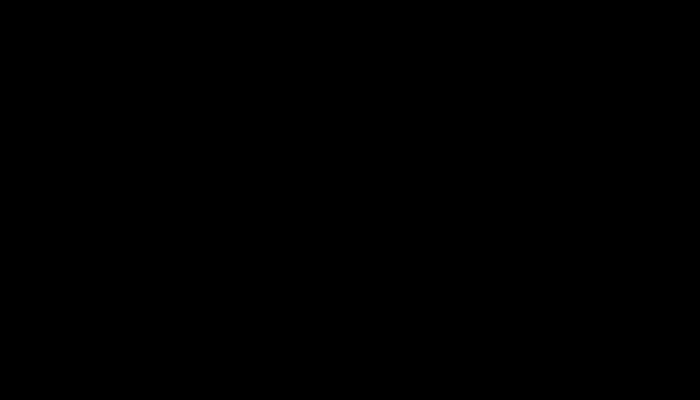

In [28]:
import folium
import geopandas as gpd
import rasterio
from rasterio.warp import transform_bounds, reproject, Resampling
import numpy as np

# --- Paths ---
tif_path = "/content/drive/MyDrive/GEDI_LAS_Comp/1982317NW_PAI_10m_georef.tif"

# --- Step 1: Load raster ---
with rasterio.open(tif_path) as src:
    data = src.read(1)  # single band
    nodata = src.nodata if src.nodata is not None else np.nan
    src_crs = src.crs
    bounds = src.bounds
    height, width = src.height, src.width

# Replace nodata with nan
data = np.where(data == nodata, np.nan, data)

# --- Step 2: Reproject raster to EPSG:4326 for Folium ---
dst_crs = "EPSG:4326"

# Transform raster bounds to WGS84
minx, miny, maxx, maxy = transform_bounds(src_crs, dst_crs, bounds.left, bounds.bottom, bounds.right, bounds.top)

# Normalize raster for display (0–1)
data_norm = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))
data_norm = np.flipud(data_norm)  # flip vertically for Folium

# --- Step 3: Reproject polygons and points to WGS84 ---
plots_wgs84 = plots_utm.to_crs(dst_crs)
gdf_points_wgs84 = gdf_out.to_crs(dst_crs)

# --- Step 4: Create Folium map ---
m = folium.Map(zoom_start=14)
minx_poly, miny_poly, maxx_poly, maxy_poly = plots_wgs84.total_bounds
m.fit_bounds([[miny_poly, minx_poly], [maxy_poly, maxx_poly]])

# --- Step 5: Add raster as ImageOverlay ---
folium.raster_layers.ImageOverlay(
    image=data_norm,
    bounds=[[miny, minx], [maxy, maxx]],
    colormap=lambda x: (x, 0, 1-x, 0.6),  # simple color mapping
    opacity=0.6,
    name="PAI 10m"
).add_to(m)

# --- Step 6: Add polygons ---
folium.GeoJson(
    data=plots_wgs84[["geometry"]].to_json(),
    name="25 m Plots",
    style_function=lambda f: {"color": "blue", "weight": 1, "fillOpacity": 0.2}
).add_to(m)

# --- Step 7: Add points ---
for _, row in gdf_points_wgs84.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        color="red",
        fill=True,
        fill_opacity=0.8
    ).add_to(m)

# --- Layer control ---
folium.LayerControl().add_to(m)

m


In [32]:
!pip install rasterstats


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 95.4 MB/s eta 0:00:00


In [35]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.crs import CRS
import numpy as np

# Path to georeferenced raster
tif_path = "/content/drive/MyDrive/GEDI_LAS_Comp/1982317NW_PAI_10m_georef.tif"

# --- Step 1: Open raster and ensure CRS is set ---
with rasterio.open(tif_path, "r+") as src:
    if src.crs is None:
        src.crs = CRS.from_epsg(6576)  # Tennessee State Plane (feet US)
    raster_crs = src.crs

# --- Step 2: Reproject polygons to raster CRS ---
gdf_out = gdf_out.to_crs(raster_crs)

# --- Step 3: Compute mean PAI for each polygon ---
mean_values = []

with rasterio.open(tif_path) as src:
    nodata = src.nodata
    for poly in gdf_out['Plot']:
        try:
            # Mask raster with polygon
            out_image, _ = mask(src, [poly], crop=True, filled=False)
            data = out_image[0]  # single band
            # Remove nodata
            if nodata is not None:
                data = data[data != nodata]
            data = data.flatten()
            mean_values.append(data.mean() if len(data) > 0 else np.nan)
        except ValueError:
            # polygon does not intersect raster
            mean_values.append(np.nan)

# --- Step 4: Append results to GeoDataFrame ---
gdf_out['mean_PAI'] = mean_values

# --- Step 5: Save updated table ---
gdf_out.to_csv("/content/drive/MyDrive/GEDI_LAS_Comp/GEDI_csvs/plots_with_mean_PAI.csv", index=False)

print(gdf_out[['Plot', 'mean_PAI']].head())


                                                Plot  mean_PAI
0  POLYGON ((595310.687 3898598.625, 595310.627 3...       NaN
1  POLYGON ((595351.55 3898636.832, 595351.49 389...       NaN
2  POLYGON ((595384.734 3897818.85, 595384.674 38...       NaN
3  POLYGON ((595510.087 3897936.502, 595510.027 3...       NaN
4  POLYGON ((595676.979 3898093.053, 595676.919 3...       NaN


In [34]:
gdf_out

,lat,lon,geolocation/solar_elevation,geolocation/local_beam_elevation,selected_l2a_algorithm,geolocation/degrade_flag,l2b_quality_flag,geolocation/digital_elevation_model,geolocation/elev_lowestmode,geolocation/elev_highestreturn,...,cover_z,product,Beam,fileName,date,Beam_Type,AOI,geometry,Plot,mean_PAI
0,35.225911,-85.952789,6.330425,1.485430,2,0,1,459.937866,447.504364,454.635834,...,"[0.43823322653770447, 0.11666984111070633, 0.0...",GEDI_L2B,BEAM1000,GEDI02_B_2024169103448_O31228_02_T05264_02_004...,2024-06-17,Power,Sewanee_Domain_GEDI02_B,POINT (1982600.979 324911.019),"POLYGON ((595310.687 3898598.625, 595310.627 3...",None
1,35.226252,-85.952335,6.330932,1.485430,2,0,1,428.120880,433.156586,444.805939,...,"[0.7545831799507141, 0.5155324339866638, 0.037...",GEDI_L2B,BEAM1000,GEDI02_B_2024169103448_O31228_02_T05264_02_004...,2024-06-17,Power,Sewanee_Domain_GEDI02_B,POINT (1982736.337 325035.052),"POLYGON ((595351.55 3898636.832, 595351.49 389...",None
2,35.218874,-85.952065,6.327698,1.486174,2,0,1,564.642151,570.258484,575.150024,...,"[0.19113504886627197, 0.0, 0.0, 0.0, 0.0, 0.0,...",GEDI_L2B,BEAM1011,GEDI02_B_2024169103448_O31228_02_T05264_02_004...,2024-06-17,Power,Sewanee_Domain_GEDI02_B,POINT (1982818.231 322349.645),"POLYGON ((595384.734 3897818.85, 595384.674 38...",None
3,35.219923,-85.950675,6.329240,1.486175,2,0,1,568.325562,574.734497,578.244446,...,"[0.007183022331446409, 0.0, 0.0, 0.0, 0.0, 0.0...",GEDI_L2B,BEAM1011,GEDI02_B_2024169103448_O31228_02_T05264_02_004...,2024-06-17,Power,Sewanee_Domain_GEDI02_B,POINT (1983233.476 322731.597),"POLYGON ((595510.087 3897936.502, 595510.027 3...",None
4,35.221319,-85.948823,6.331296,1.486176,2,0,1,567.739868,575.495239,580.536133,...,"[0.2909294664859772, 0.0, 0.0, 0.0, 0.0, 0.0, ...",GEDI_L2B,BEAM1011,GEDI02_B_2024169103448_O31228_02_T05264_02_004...,2024-06-17,Power,Sewanee_Domain_GEDI02_B,POINT (1983786.323 323239.83),"POLYGON ((595676.979 3898093.053, 595676.919 3...",None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,35.217719,-85.952949,-12.517460,1.564300,2,0,1,572.046143,556.305054,582.342285,...,"[0.8570812940597534, 0.8301624059677124, 0.781...",GEDI_L2B,BEAM1000,GEDI02_B_2021135083748_O13719_03_T08849_02_003...,2021-05-15,Power,Sewanee_Domain_GEDI02_B,POINT (1982554.489 321929.091),"POLYGON ((595305.662 3897689.901, 595305.602 3...",None
318,35.217371,-85.952489,-12.517323,1.564300,1,0,1,574.444214,558.450867,585.049988,...,"[0.8555208444595337, 0.8305472731590271, 0.770...",GEDI_L2B,BEAM1000,GEDI02_B_2021135083748_O13719_03_T08849_02_003...,2021-05-15,Power,Sewanee_Domain_GEDI02_B,POINT (1982691.917 321802.262),"POLYGON ((595347.924 3897651.678, 595347.864 3...",None
319,35.217022,-85.952029,-12.517188,1.564300,1,0,1,574.485535,560.517456,585.430725,...,"[0.8464522957801819, 0.8261682391166687, 0.743...",GEDI_L2B,BEAM1000,GEDI02_B_2021135083748_O13719_03_T08849_02_003...,2021-05-15,Power,Sewanee_Domain_GEDI02_B,POINT (1982829.342 321675.43),"POLYGON ((595390.186 3897613.454, 595390.126 3...",None
320,35.216673,-85.951569,-12.517052,1.564300,2,0,1,574.485535,556.055847,583.479248,...,"[0.7971569299697876, 0.7649346590042114, 0.685...",GEDI_L2B,BEAM1000,GEDI02_B_2021135083748_O13719_03_T08849_02_003...,2021-05-15,Power,Sewanee_Domain_GEDI02_B,POINT (1982966.785 321548.459),"POLYGON ((595432.453 3897575.188, 595432.393 3...",None


30-40 minute run time

In [ ]:
# import laspy
# import geopandas as gpd
# import pandas as pd
# import numpy as np
# from shapely.geometry import Point

# # -----------------------------
# # Step 1: Prepare GEDI Plots
# # -----------------------------
# gdf_out = gdf_out.set_crs("EPSG:4326", allow_override=True)

# plots = gpd.GeoDataFrame(
#     gdf_out.drop(columns="geometry"),  # drop original point geometry
#     geometry=gdf_out["Plot"],          # keep Plot polygons
#     crs="EPSG:26916"                   # Plot polygons created in UTM 16N
# )

# # Reproject to WGS84 for matching LAS points
# plots_wgs = plots.to_crs(epsg=4326)

# # -----------------------------
# # Step 2: Open LAS file in chunks
# # -----------------------------
# las_file = "/content/drive/MyDrive/GEDI_LAS_Comp/1982317NW.las"
# results = []
# chunk_size = 2_000_000  # 2M points per chunk

# # Get bounding box of all plots in LAS CRS (EPSG:6576)
# plots_bbox = plots.to_crs(epsg=6576).total_bounds  # [minx, miny, maxx, maxy]

# with laspy.open(las_file) as lasf:
#     for chunk in lasf.chunk_iterator(chunk_size):
#         # Extract XYZ as numpy arrays
#         x = np.array(chunk.x)
#         y = np.array(chunk.y)
#         z = np.array(chunk.z)

#         # -----------------------------
#         # Step 3: Filter by bounding box
#         # -----------------------------
#         mask = (
#             (x >= plots_bbox[0]) & (x <= plots_bbox[2]) &
#             (y >= plots_bbox[1]) & (y <= plots_bbox[3])
#         )
#         if not mask.any():
#             continue  # skip empty chunks

#         # -----------------------------
#         # Step 4: Make GeoDataFrame
#         # -----------------------------
#         las_df = pd.DataFrame({"X": x[mask], "Y": y[mask], "Z": z[mask]})
#         las_gdf = gpd.GeoDataFrame(
#             las_df,
#             geometry=gpd.points_from_xy(las_df["X"], las_df["Y"]),
#             crs="EPSG:6576"  # LAS CRS
#         ).to_crs(epsg=4326)   # reproject to WGS84

#         # -----------------------------
#         # Step 5: Spatial join with plots
#         # -----------------------------
#         las_in_chunk = gpd.sjoin(las_gdf, plots_wgs, how="inner", predicate="within")

#         if not las_in_chunk.empty:
#             # Keep LAS points as active geometry
#             las_in_chunk = las_in_chunk.set_geometry("geometry")
#             # Convert Plot polygon to WKT for reference
#             las_in_chunk["Plot_WKT"] = las_in_chunk["Plot"].apply(lambda p: p.wkt)
#             # Drop original Plot geometry to avoid GeoJSON errors
#             las_in_chunk = las_in_chunk.drop(columns="Plot")
#             results.append(las_in_chunk)

# # -----------------------------
# # Step 6: Concatenate all chunks
# # -----------------------------
# if results:
#     las_in_plots = pd.concat(results, ignore_index=True)
#     print(f"✅ Total LAS points inside GEDI plots: {len(las_in_plots)}")
# else:
#     las_in_plots = gpd.GeoDataFrame(columns=las_gdf.columns)
#     print("⚠️ No LAS points found inside plots")

# # -----------------------------
# # Step 7: Save results
# # -----------------------------
# # GeoJSON (geometry = LAS points)
# las_in_plots.to_file("/content/drive/MyDrive/GEDI_LAS_Comp/GEDI_csvs/las_in_plots.geojson", driver="GeoJSON")
# # CSV (all attributes including Plot WKT)
# las_in_plots.to_csv("/content/drive/MyDrive/GEDI_LAS_Comp/GEDI_csvs/las_in_plots.csv", index=False)


✅ Total LAS points inside GEDI plots: 2265679


# Check Point:
Due to the limiaitons of the Colab and aviabale Ram the steps above have bene consolidated to thsi derived product



Fetch Check Point

see and fetch :

In [ ]:
# record_id = #"16929466"
# # For restricted access, you'd need an access token
# # ACCESS_TOKEN = "YOUR_ZENODO_ACCESS_TOKEN"

# # Fetch record metadata to get file links
# r = requests.get(f"https://zenodo.org/api/records/{record_id}") # , params={'access_token': ACCESS_TOKEN}
# r.raise_for_status()
# files = r.json()['files']

# # Download each file
# for file_info in files:
#     filename = file_info['key']
#     download_url = file_info['links']['self']

#     with requests.get(download_url, stream=True) as r_file:
#         r_file.raise_for_status()
#         with open(filename, 'wb') as f:
#             for chunk in r_file.iter_content(chunk_size=8192):
#                 f.write(chunk)
#         print(f"Downloaded: {filename}")

Plot the corelation for the .las avergaed Z value per 25m plot and the GEDI rh100 value

In [ ]:
# import pandas as pd
# import geopandas as gpd

# # -----------------------------
# # Step 1: Load CSV with rh100 per plot
# # -----------------------------
# gdf_out = gdf_out.set_crs("EPSG:4326", allow_override=True)
# plots = gpd.GeoDataFrame(
#     gdf_out.drop(columns="geometry"),
#     geometry=gdf_out["Plot"],          # polygons are in the "Plot" column
#     crs="EPSG:26916"
# )

# # Assign a unique Plot ID to each polygon for grouping
# plots["Plot_ID"] = range(len(plots))

# # Reproject to WGS84 (to match LAS points)
# plots_wgs = plots.to_crs(epsg=4326)

# # -----------------------------
# # Step 2: Load LAS points inside plots
# # -----------------------------
# las_in_plots = pd.read_csv("/content/drive/MyDrive/GEDI_LAS_Comp/GEDI_csvs/las_in_plots.csv")

# # Convert LAS points to GeoDataFrame
# las_gdf = gpd.GeoDataFrame(
#     las_in_plots,
#     geometry=gpd.points_from_xy(las_in_plots.X, las_in_plots.Y),
#     crs="EPSG:4326"
# )

# # -----------------------------
# # Step 3: Spatial join to assign Plot_ID to each LAS point
# # -----------------------------
# las_with_plot = gpd.sjoin(
#     las_gdf,
#     plots_wgs[["Plot_ID", "geometry"]],
#     how="inner",
#     predicate="within",
#     lsuffix="las",
#     rsuffix="plot"
# )

# # -----------------------------
# # Step 4: Compute average LAS Z per plot
# # -----------------------------
# avg_las_per_plot = las_with_plot.groupby("Plot_ID")["Z"].mean().reset_index()
# avg_las_per_plot.rename(columns={"Z": "avg_las_plot"}, inplace=True)

# # -----------------------------
# # Step 5: Merge with GEDI rh100
# # -----------------------------
# plots_rh100 = plots[["Plot_ID", "rh100"]]  # ensure we keep Plot_ID + rh100

# correlation_df = pd.merge(
#     plots_rh100,
#     avg_las_per_plot,
#     on="Plot_ID",
#     how="inner"
# )

# print(correlation_df.head())
# print(f"✅ Correlation dataframe ready with {len(correlation_df)} plots")


Empty DataFrame
Columns: [Plot_ID, rh100, avg_las_plot]
Index: []
✅ Correlation dataframe ready with 0 plots


In [ ]:
import pandas as pd

# -----------------------------
# Step 1: Load LAS–GEDI merged CSV
# -----------------------------
las_in_plots = pd.read_csv("/content/drive/MyDrive/GEDI_LAS_Comp/GEDI_csvs/las_in_plots.csv")

# Quick check of available columns
print("CSV columns:", las_in_plots.columns.tolist())

# -----------------------------
# Step 2: Compute avg LAS Z per plot
# -----------------------------
# If there's already a unique plot identifier in the CSV, use it.
# Otherwise, group by 'Plot_WKT' (or another plot field).
group_field = "Plot_WKT" if "Plot_WKT" in las_in_plots.columns else "Plot_ID"

avg_las_per_plot = (
    las_in_plots.groupby(group_field)["Z"]
    .mean()
    .reset_index()
    .rename(columns={"Z": "avg_las_plot"})
)

# -----------------------------
# Step 3: Extract unique rh100 per plot
# -----------------------------
rh100_per_plot = (
    las_in_plots.groupby(group_field)["rh100"]
    .first()  # all rows in a plot share same rh100
    .reset_index()
)

# -----------------------------
# Step 4: Merge into correlation dataframe
# -----------------------------
correlation_df = pd.merge(rh100_per_plot, avg_las_per_plot, on=group_field, how="inner")

print(correlation_df.head())
print(f"✅ Correlation dataframe ready with {len(correlation_df)} plots")

# -----------------------------
# Step 5 (Optional): Compute correlation coefficient
# -----------------------------
corr_value = correlation_df["rh100"].corr(correlation_df["avg_las_plot"])
print(f"📈 Pearson correlation (rh100 vs avg_las_plot): {corr_value:.3f}")


CSV columns: ['X', 'Y', 'Z', 'geometry', 'index_right', 'lat', 'lon', 'geolocation/solar_elevation', 'geolocation/local_beam_elevation', 'selected_l2a_algorithm', 'geolocation/degrade_flag', 'l2b_quality_flag', 'geolocation/digital_elevation_model', 'geolocation/elev_lowestmode', 'geolocation/elev_highestreturn', 'rh100', 'shot_number', 'num_detectedmodes', 'sensitivity', 'land_cover_data/leaf_off_flag', 'pgap_theta_z', 'pai', 'pai_z', 'fhd_normal', 'pavd_z', 'cover', 'cover_z', 'product', 'Beam', 'fileName', 'date', 'Plot_WKT']
                                            Plot_WKT  rh100  avg_las_plot
0  POLYGON ((595285.5602062192 3898466.759217509,...   4604   1641.097713
1  POLYGON ((595291.0913920404 3897765.749965638,...      0   1945.339247
2  POLYGON ((595294.7291942913 3898688.3000771035...    880   1415.522983
3  POLYGON ((595297.0786733279 3897699.1083609597...      0   1947.972296
4  POLYGON ((595298.0675551336 3898120.9037817526...   2530   1913.077312
✅ Correlation datafra

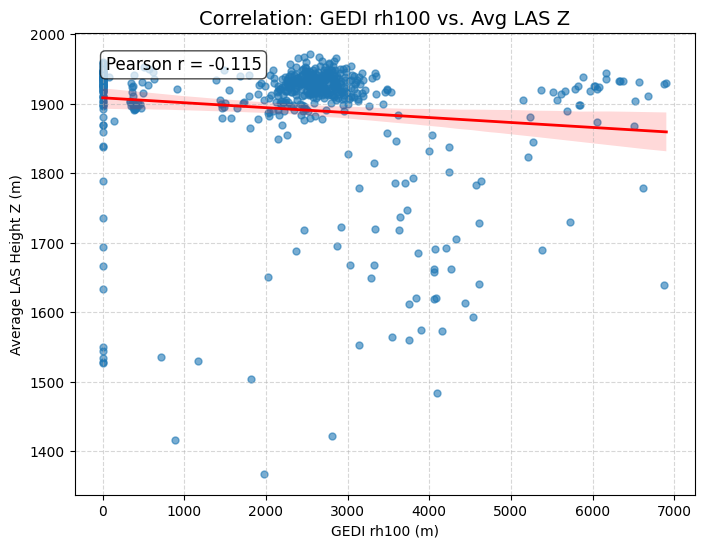

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Scatterplot with regression line
# -----------------------------
plt.figure(figsize=(8, 6))
sns.regplot(
    data=correlation_df,
    x="rh100",
    y="avg_las_plot",
    scatter_kws={"s": 25, "alpha": 0.6},  # smaller, semi-transparent points
    line_kws={"color": "red", "linewidth": 2}
)

plt.title("Correlation: GEDI rh100 vs. Avg LAS Z", fontsize=14)
plt.xlabel("GEDI rh100 (m)")
plt.ylabel("Average LAS Height Z (m)")
plt.grid(True, linestyle="--", alpha=0.5)

# Show correlation value on plot
plt.text(
    0.05, 0.95,
    f"Pearson r = {correlation_df['rh100'].corr(correlation_df['avg_las_plot']):.3f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment="top",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
)

plt.show()
